In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng=np.random.default_rng(42)

# 5.3 Bayes==frequentist?

## mean and covar

In [3]:
ndim=5
mu0=np.array([1,5,2,7,2])

In [4]:
Corr=rng.uniform(low=-0.1,high=0.1,size=[ndim,ndim])
Corr+=Corr.T
np.fill_diagonal(Corr,1)
sigmas=rng.uniform(low=1e-3,high=1,size=ndim)
Cov=np.einsum('ij,i,j->ij',Corr,sigmas,sigmas)

In [5]:
mu0

array([1, 5, 2, 7, 2])

In [6]:
Cov

array([[ 3.81983842e-02,  7.57061475e-03,  4.01354315e-04,
        -4.57188512e-04, -3.94628945e-03],
       [ 7.57061475e-03,  2.18326565e-01,  2.98166285e-03,
        -4.60008523e-03, -1.24585460e-02],
       [ 4.01354315e-04,  2.98166285e-03,  2.00345420e-03,
        -1.57515768e-04,  2.53332589e-03],
       [-4.57188512e-04, -4.60008523e-03, -1.57515768e-04,
         2.40669311e-02,  1.11269338e-02],
       [-3.94628945e-03, -1.24585460e-02,  2.53332589e-03,
         1.11269338e-02,  4.66988959e-01]])

## generate 1000 universes and v for the holy book

In [7]:
nuniverses=100000
universes=rng.multivariate_normal(mu0,Cov,size=nuniverses)

In [8]:
universes.shape

(100000, 5)

In [9]:
v=np.array([0.4,3,0.5,1,2])
alpha_range=1

## become human

In [10]:
def model(alpha):
    mu_alph=mu0[:,np.newaxis]+alpha*v[:,np.newaxis]
    return mu_alph

In [11]:
def log_likelihood(data,alpha):
    logl=-0.5*np.einsum("ijk,jm,imk->ik",data-model(alpha),np.linalg.pinv(Cov),(data-model(alpha)))-0.5*np.log(2*np.pi*np.linalg.det(Cov))
    #i: 1000 universes
    #j,m: 5 dimensions
    #k: 300 alphas
    return logl
def logprior(alpha):
    if len(alpha)>1:
        prior=np.zeros(alpha.shape)-np.log(alpha_range)
        sel=np.abs(alpha)>alpha_range/2
        prior[sel]=-np.inf
    else:
        if np.abs(alpha)>alpha_range/2:
            return -np.inf
        else:
            prior=-np.log(alpha_range)
    return prior

In [12]:
def log_posterior_prob(data,alpha):
    return log_likelihood(data,alpha)+logprior(alpha)

In [13]:
alpha_arr=np.linspace(-1,1,500)

In [14]:
universes.shape

(100000, 5)

In [15]:
post=log_posterior_prob(universes[:,:,np.newaxis],alpha_arr)

In [16]:
post.shape

(100000, 500)

Text(0, 0.5, '$P(\\alpha|{\\bf d})$')

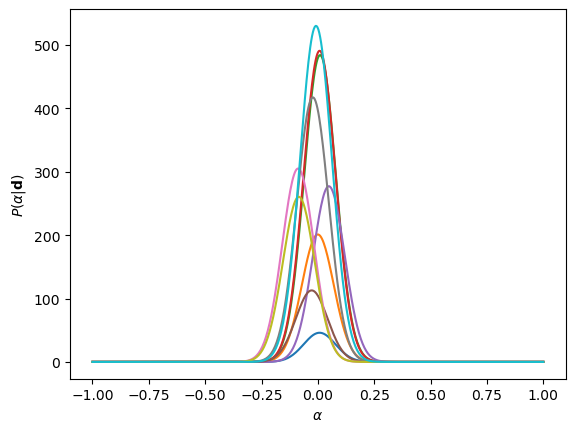

In [17]:
for i in range(10):
    plt.plot(alpha_arr,np.exp(post[i]))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$P(\alpha|{\bf d})$')

In [18]:
def get_conf_int(p,grid):
    sel_finite=np.isfinite(p)
    p=p[sel_finite]
    grid=grid[sel_finite]
    argsort_post=np.argsort(p)   #sort by posterior probability, makes evaluation easier
    cumsum=np.cumsum(p[argsort_post])/np.sum(p)   #for this part actually a normalization that normalizes the sum of all evaluated probabilities to 1 is more suitable
    in_confidence_region = cumsum>=1-0.683 #this discards the lowest posterior probability points until a total of 31.7% of the probability is reached
    return np.min(grid[argsort_post[in_confidence_region]]),np.max(grid[argsort_post[in_confidence_region]])

In [ ]:
ranges=np.array([get_conf_int(np.exp(p),alpha_arr) for p in post])

In [ ]:
truth_in_range_frac=np.sum((ranges[:,1]>=0)&(ranges[:,0]<=0))/nuniverses

In [ ]:
print(f"{truth_in_range_frac*100:.1f}% of the measurements give the true alpha in the 68.3% range")